## A. 5-day forecast prices v temperature

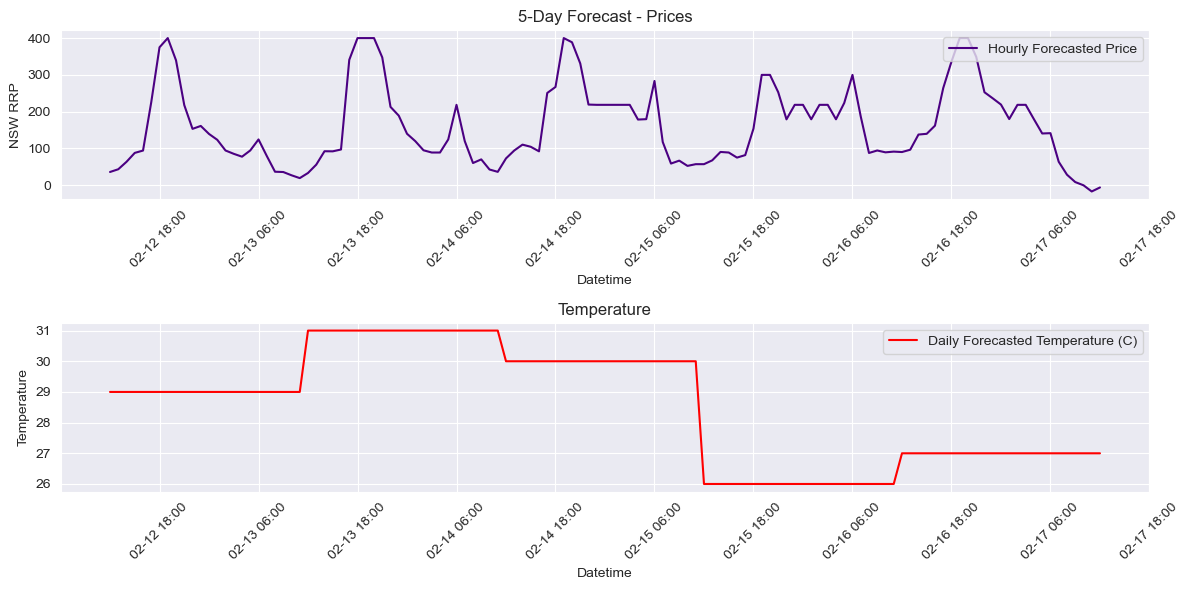

In [1]:
# Removing warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import requests
from datetime import datetime, timedelta

def fetch_data(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

def process_data(df1, df2, df3):
    df1['DateTime.1'] = pd.to_datetime(df1['DateTime.1'])
    df1['DateTime'] = pd.to_datetime(df1['DateTime'])
    df2['DateTime'] = pd.to_datetime(df2['DateTime'])
    df2['DateTime.2'] = pd.to_datetime(df2['DateTime.2'])

    # 1st df: historical data
    historical_df = df1[['DateTime.1', 'NSW1.Price_5min']].copy()
    historical_df = historical_df.resample('H', on='DateTime.1').mean()

    # 2nd df: forecasting data
    forecasting_df = df1[['DateTime', 'NSW1.predispatch 7 day RRP']].copy()
    forecasting_df = forecasting_df.resample('H', on='DateTime').mean()

    price_df = historical_df.merge(forecasting_df, left_index=True, right_index=True)

    price_df['NSW1.predispatch 7 day RRP'] = np.where(price_df['NSW1.Price_5min'].notnull(), np.nan, price_df['NSW1.predispatch 7 day RRP'])

    # Cap the values of the forecasted column at 400
    price_df['NSW1.predispatch 7 day RRP'] = np.clip(price_df['NSW1.predispatch 7 day RRP'], None, 400)

    # 3rd df: historical temperature data
    temperature_df = df2[['DateTime', 'NSW1.Temperature']].copy()
    temperature_df = temperature_df.resample('H', on='DateTime').mean()
    
    # 4th df: forecasted temperature data
    NSW_temp = df3[df3['location'] == 'Sydney'].iloc[:, 1:]
    NSW_temp = NSW_temp.reset_index(drop=True)
    NSW_temp = NSW_temp.melt(var_name='Date_Type', value_name='Temperature')
    current_date = datetime.now().replace(hour=12, minute=0, second=0, microsecond=0)

    def generate_date_string(delta):
        return (current_date + timedelta(days=delta)).replace(hour=12).strftime('%Y-%m-%d %H:%M:%S')

    date_mapping = {'Today': generate_date_string(0)}
    for i in range(1, len(NSW_temp)):
        date_mapping[f'D+{i}'] = generate_date_string(i)

    NSW_temp['DateTime'] = NSW_temp['Date_Type'].map(date_mapping)
    NSW_temp.drop(columns=['Date_Type'], inplace=True)
    NSW_temp['DateTime'] = pd.to_datetime(NSW_temp['DateTime'])
    NSW_temp.set_index('DateTime', inplace=True)
    NSW_temp_hourly = NSW_temp.resample('H').ffill()

    final_df = price_df.merge(temperature_df, left_index=True, right_index=True)
    final_df = final_df.merge(NSW_temp_hourly, left_index=True, right_index=True, suffixes=('_historical', '_forecasted'))
    return final_df

def priceplot(ax, final_df):
    # Plotting the historical and forecast data for prices
    sns.lineplot(x=final_df.index, y=final_df['NSW1.predispatch 7 day RRP'], color='indigo', label='Hourly Forecasted Price', ax=ax)
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('NSW RRP')
    ax.set_title('5-Day Forecast - Prices')
    ax.legend(loc='upper right')
    ax.grid(True)

def tempplot(ax, final_df):
    # Plotting the historical and forecast data for temperature
    sns.lineplot(x=final_df.index, y=final_df['Temperature'], color='red', label='Daily Forecasted Temperature (C)')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Temperature')
    midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
    ax.set_xticks(midpoints, [dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
    ax.set_title('Temperature')
    ax.legend(loc='upper right')
    ax.grid(True)

def main():
    # Removing warnings
    warnings.filterwarnings("ignore", "is_categorical_dtype")
    warnings.filterwarnings("ignore", "use_inf_as_na")

    # Get the current date
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Generate URLs with the current date
    price_actual_url = f'https://neopoint.com.au/Service/Csv?f=101%20Prices%5CRegion%20RRP%20and%20Latest%20Projection%2030min&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    price_forecast_url = f'https://neopoint.com.au/Service/Csv?f=105%20PASA%20and%20Predispatch%5CWeather%20and%20Demand&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    regiontemp_url = f'https://neopoint.com.au/Service/Csv?f=301%20Weather%5C5%20Days%20Forecast&from={current_date}%2000%3A00&period=Weekly&instances=&section=-1&key=PHO2312'

    # Read data
    df1 = fetch_data(price_actual_url)
    df2 = fetch_data(price_forecast_url)
    df3 = fetch_data(regiontemp_url)

    # Process data
    final_df = process_data(df1, df2, df3)

    # Set Seaborn style to "dark"
    sns.set_style("dark")

    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True

    # Create subplots with the specified figure size and share the x-axis
    f, axes = plt.subplots(2, 1)

    # Call your functions for each subplot, passing the respective axes and final_df
    priceplot(axes[0], final_df)  
    tempplot(axes[1], final_df)   

    plt.tight_layout()  
    plt.show()

if __name__ == "__main__":
    main()

## B. 7-day energy generation

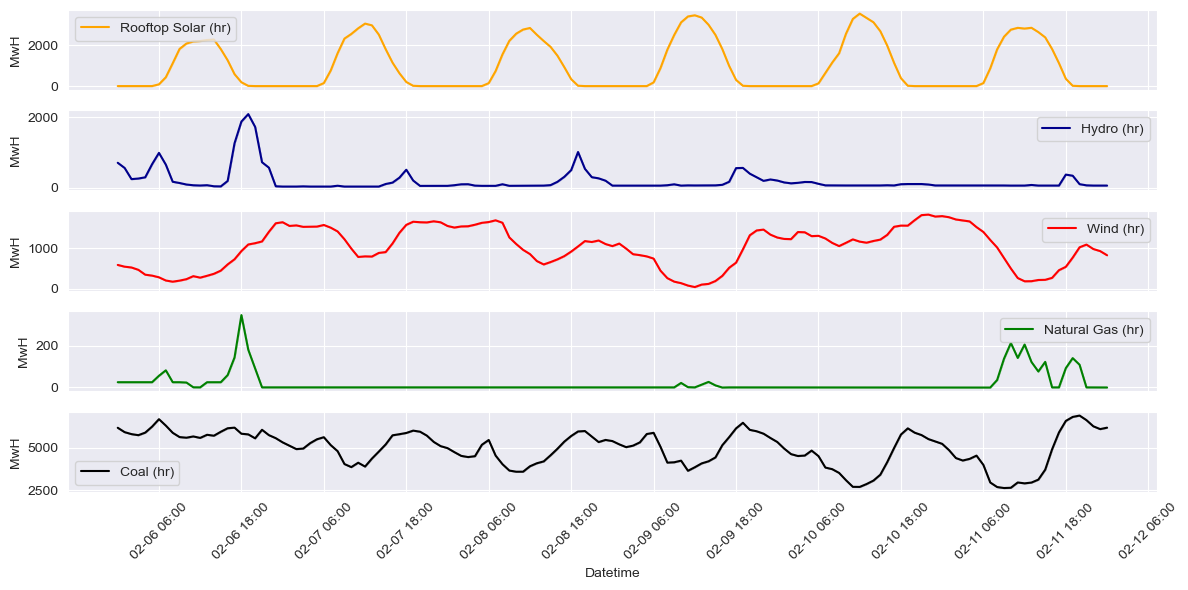

In [2]:
# Removing warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import requests
from datetime import datetime, timedelta


def fetch_data(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

def process_energy_data(df4, df5, df6):
    df4['DateTime'] = pd.to_datetime(df4['DateTime'])
    df5['DateTime'] = pd.to_datetime(df5['DateTime'])
    df6['DateTime'] = pd.to_datetime(df6['DateTime'])

    # 4th df: Generated rooftop solar data
    rooftop_actual = df4[['DateTime', 'Rooftop PV MEASUREMENT']].copy()
    rooftop_actual = rooftop_actual.resample('H', on='DateTime').mean()

    # 5th df: Forecasted rooftop solar data
    rooftop_forecast = df5[['DateTime', 'POWERMEAN']].copy()
    rooftop_forecast = rooftop_forecast.resample('H', on='DateTime').mean()

    rooftop_df = pd.concat([rooftop_actual, rooftop_forecast])

    # 6th df: Other energy sources data
    hydro_df = df6[['DateTime', 'Hydro.Generation']].copy()
    hydro_df = hydro_df.resample('H', on='DateTime').mean()
    wind_df = df6[['DateTime', 'Wind.Generation']].copy()
    wind_df = wind_df.resample('H', on='DateTime').mean()
    gas_df = df6[['DateTime', 'Natural Gas.Generation']].copy()
    gas_df = gas_df.resample('H', on='DateTime').mean()
    coal_df = df6[['DateTime', 'Black Coal.Generation']].copy()
    coal_df = coal_df.resample('H', on='DateTime').mean()


    # Concatenate rooftop, hydro, wind data
    hydrosolar_df = pd.concat([hydro_df, rooftop_df])
    hydrosolarwind_df = pd.concat([hydrosolar_df, wind_df])
    hydrosolarwindcoal_df = pd.concat([hydrosolarwind_df, coal_df])
    final_df = pd.concat([gas_df, hydrosolarwindcoal_df])
    
    return final_df
    
def main():
    # Removing warnings
    warnings.filterwarnings("ignore", "is_categorical_dtype")
    warnings.filterwarnings("ignore", "use_inf_as_na")

    # Get the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    weekly_data = (datetime.now() - timedelta(days=6)).strftime('%Y-%m-%d')
    
    # Generate URLs with the current date
    rooftopsolar_actual_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Generation&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    rooftopsolar_forecast_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Forecast&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    energy_source_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRegional%205min%20generation%20by%20fuel&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    
    # Read data
    df4 = fetch_data(rooftopsolar_actual_url)
    df5 = fetch_data(rooftopsolar_forecast_url)
    df6 = fetch_data(energy_source_url)

    # Process data
    final_df = process_energy_data(df4, df5, df6)

    # Set Seaborn style to "dark"
    sns.set_style("dark")
    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True

    # Filter data up to the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    final_df = final_df[final_df.index <= current_date]

    # Create subplots with the specified figure size and share the x-axis
    f, axes = plt.subplots(5, 1, sharex=True)

    sns.lineplot(x=final_df.index, y=final_df['Rooftop PV MEASUREMENT'], color='orange', label='Rooftop Solar (hr)', ax=axes[0])
    sns.lineplot(x=final_df.index, y=final_df['Hydro.Generation'], color='darkblue', label='Hydro (hr)', ax=axes[1])
    sns.lineplot(x=final_df.index, y=final_df['Wind.Generation'], color='red', label='Wind (hr)', ax=axes[2])
    sns.lineplot(x=final_df.index, y=final_df['Natural Gas.Generation'], color='green', label='Natural Gas (hr)', ax=axes[3])
    sns.lineplot(x=final_df.index, y=final_df['Black Coal.Generation'], color='black', label='Coal (hr)', ax=axes[4])

    for ax in axes:
        ax.set_xlabel('Datetime')
        ax.set_ylabel('MwH')
        midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
        ax.set_xticks(midpoints)
        ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
        ax.grid(True)

    plt.tight_layout() 
    plt.show()

if __name__ == "__main__":
    main()

## B. 7-day energy generation

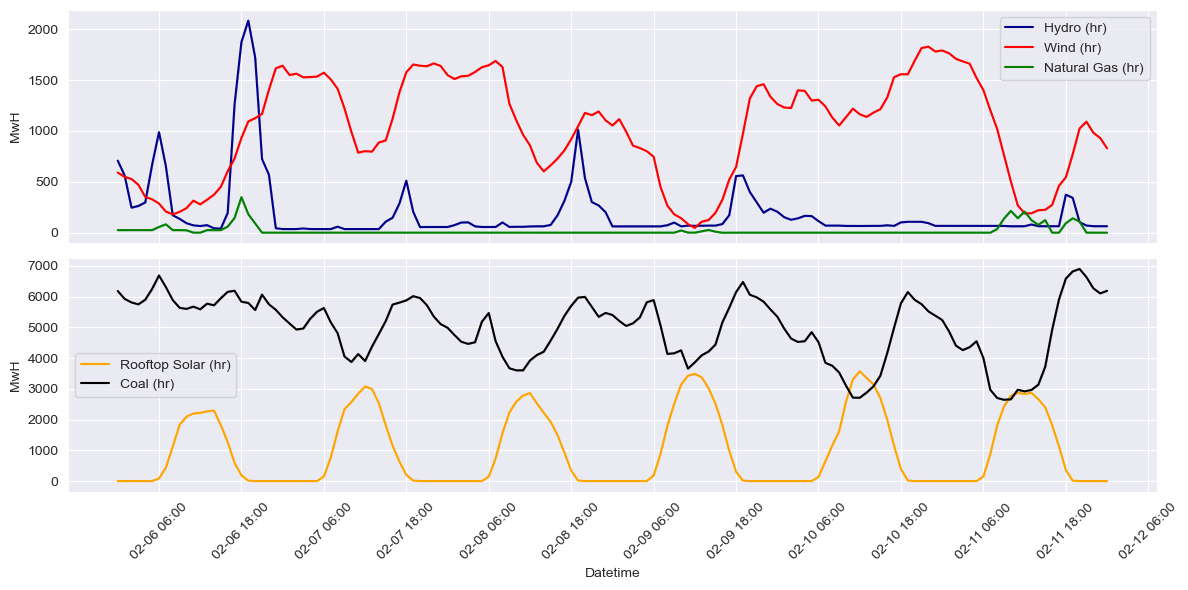

In [3]:
# Removing warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import requests
from datetime import datetime, timedelta


def fetch_data(url):
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    return data

def process_energy_data(df4, df5, df6):
    df4['DateTime'] = pd.to_datetime(df4['DateTime'])
    df5['DateTime'] = pd.to_datetime(df5['DateTime'])
    df6['DateTime'] = pd.to_datetime(df6['DateTime'])

    # 4th df: Generated rooftop solar data
    rooftop_actual = df4[['DateTime', 'Rooftop PV MEASUREMENT']].copy()
    rooftop_actual = rooftop_actual.resample('H', on='DateTime').mean()

    # 5th df: Forecasted rooftop solar data
    rooftop_forecast = df5[['DateTime', 'POWERMEAN']].copy()
    rooftop_forecast = rooftop_forecast.resample('H', on='DateTime').mean()

    rooftop_df = pd.concat([rooftop_actual, rooftop_forecast])

    # 6th df: Other energy sources data
    hydro_df = df6[['DateTime', 'Hydro.Generation']].copy()
    hydro_df = hydro_df.resample('H', on='DateTime').mean()
    wind_df = df6[['DateTime', 'Wind.Generation']].copy()
    wind_df = wind_df.resample('H', on='DateTime').mean()
    gas_df = df6[['DateTime', 'Natural Gas.Generation']].copy()
    gas_df = gas_df.resample('H', on='DateTime').mean()
    coal_df = df6[['DateTime', 'Black Coal.Generation']].copy()
    coal_df = coal_df.resample('H', on='DateTime').mean()


    # Concatenate rooftop, hydro, wind data
    hydrosolar_df = pd.concat([hydro_df, rooftop_df])
    hydrosolarwind_df = pd.concat([hydrosolar_df, wind_df])
    hydrosolarwindcoal_df = pd.concat([hydrosolarwind_df, coal_df])
    final_df = pd.concat([gas_df, hydrosolarwindcoal_df])
    
    return final_df
    
def main():
    # Removing warnings
    warnings.filterwarnings("ignore", "is_categorical_dtype")
    warnings.filterwarnings("ignore", "use_inf_as_na")

    # Get the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    weekly_data = (datetime.now() - timedelta(days=6)).strftime('%Y-%m-%d')
    
    # Generate URLs with the current date
    rooftopsolar_actual_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Generation&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    rooftopsolar_forecast_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRooftop%20PV%20Forecast&from={current_date}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    energy_source_url = f'https://neopoint.com.au/Service/Csv?f=801%20Fuel%5CRegional%205min%20generation%20by%20fuel&from={weekly_data}%2000%3A00&period=Weekly&instances=NSW1&section=-1&key=PHO2312'
    
    # Read data
    df4 = fetch_data(rooftopsolar_actual_url)
    df5 = fetch_data(rooftopsolar_forecast_url)
    df6 = fetch_data(energy_source_url)

    # Process data
    final_df = process_energy_data(df4, df5, df6)

    # Set Seaborn style to "dark"
    sns.set_style("dark")
    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True

    # Filter data up to the current date
    current_date = datetime.now().strftime('%Y-%m-%d')
    final_df = final_df[final_df.index <= current_date]

    # Create subplots with the specified figure size and share the x-axis
    f, axes = plt.subplots(2, 1, sharex=True)

    sns.lineplot(x=final_df.index, y=final_df['Rooftop PV MEASUREMENT'], color='orange', label='Rooftop Solar (hr)', ax=axes[1])
    sns.lineplot(x=final_df.index, y=final_df['Hydro.Generation'], color='darkblue', label='Hydro (hr)', ax=axes[0])
    sns.lineplot(x=final_df.index, y=final_df['Wind.Generation'], color='red', label='Wind (hr)', ax=axes[0])
    sns.lineplot(x=final_df.index, y=final_df['Natural Gas.Generation'], color='green', label='Natural Gas (hr)', ax=axes[0])
    sns.lineplot(x=final_df.index, y=final_df['Black Coal.Generation'], color='black', label='Coal (hr)', ax=axes[1])

    for ax in axes:
        ax.set_xlabel('Datetime')
        ax.set_ylabel('MwH')
        midpoints = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='12H') + pd.Timedelta(hours=6)
        ax.set_xticks(midpoints)
        ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)
        ax.grid(True)

    plt.tight_layout() 
    plt.show()

if __name__ == "__main__":
    main()

## C. 7-day Demand v Price

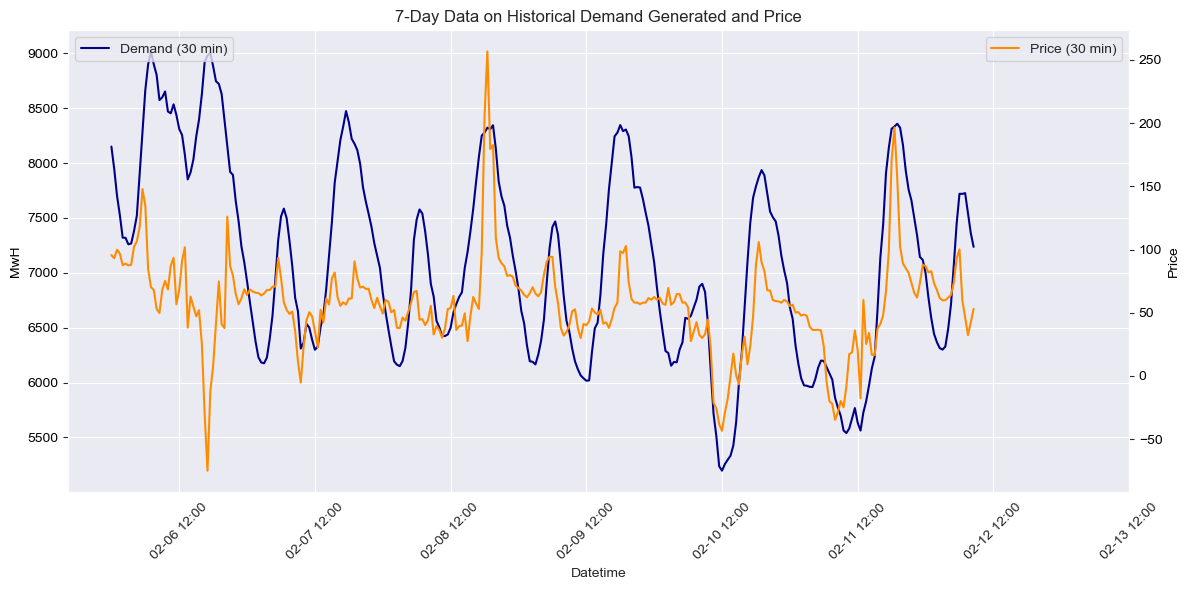

In [4]:
# Removing warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import requests
from datetime import datetime, timedelta

def fetch_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)
        return pd.read_csv(StringIO(response.text))
    except Exception as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def process_histdemandprice_data(histdemand, pricedemand):
    histdemand['DateTime'] = pd.to_datetime(histdemand['DateTime'])
    pricedemand['DateTime'] = pd.to_datetime(pricedemand['DateTime'])

    # 1st df: historical demand data
    histdata_df = histdemand[['DateTime', 'NSW1.Demand_5min']].copy()
    histdata_df = histdata_df.resample('30T', on='DateTime').mean()
    histdata_df = histdata_df.rename(columns={'NSW1.Demand_5min': 'NSW1.Demand_30min'})

    # 2nd df: price data
    pricedata_df = pricedemand[['DateTime', 'Price_5min']].copy()
    pricedata_df = pricedata_df.resample('30T', on='DateTime').mean()
    pricedata_df = pricedata_df.rename(columns={'Price_5min': 'Price_30min'})

    demand_df = histdata_df.merge(pricedata_df, left_index=True, right_index=True)
    return demand_df

def demandplot(ax, demand_df):
    sns.lineplot(x=demand_df.index, y=demand_df['NSW1.Demand_30min'], color='darkblue', label='Demand (30 min)', ax=ax)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MwH', color='black')
    ax.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for price
    ax2 = ax.twinx()
    sns.lineplot(x=demand_df.index, y=demand_df['Price_30min'], color='darkorange', label='Price (30 min)', ax=ax2)
    ax2.set_ylabel('Price', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    ax.set_title('7-Day Data on Historical Demand Generated and Price')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set x-axis ticks and labels
    midpoints = pd.date_range(start=demand_df.index.min(), end=demand_df.index.max(), freq='D') + pd.Timedelta(hours=12)
    ax.set_xticks(midpoints)
    ax.set_xticklabels([dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45)

    ax.grid(True)

def main():
    # Get the date for one week ago from today
    one_week_ago = datetime.now() - timedelta(days=6)

    # List to store the dataframes
    histdemand_urls = []
    pricedemand_urls = []

    # Generate URLs for historical demand and price data for each day of the week
    for i in range(7):
        day = one_week_ago + timedelta(days=i)
        current_date = day.strftime('%Y-%m-%d')
        histdemand_url = f'https://www.neopoint.com.au/Service/Csv?f=103%20Generation%5CRegion%20Demand%20and%20Availability&from={current_date}%2000%3A00&period=Daily&instances=Generator%3BNSW1&section=-1&key=PHO2312'
        pricedemand_url = f'https://www.neopoint.com.au/Service/Csv?f=101%20Prices%5CRegion%20Price%205min&from={current_date}%2000%3A00&period=Daily&instances=NSW1&section=-1&key=PHO2312'
        histdemand_urls.append(histdemand_url)
        pricedemand_urls.append(pricedemand_url)

    # Fetch data for each day and concatenate them into a single dataframe
    histdemand_dfs = [fetch_data(url) for url in histdemand_urls]
    pricedemand_dfs = [fetch_data(url) for url in pricedemand_urls]
    histdemand = pd.concat(histdemand_dfs, ignore_index=True)
    pricedemand = pd.concat(pricedemand_dfs, ignore_index=True)
    
    # Process data
    final_df = process_histdemandprice_data(histdemand, pricedemand)

    # Set Seaborn style to "dark"
    sns.set_style("dark")

    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True

    # Create a single subplot
    fig, ax = plt.subplots()

    # Call the function to plot the demand and price data
    demandplot(ax, final_df)  

    plt.tight_layout()  
    plt.show()

if __name__ == "__main__":
    main()

## D. Same-day temperature by state

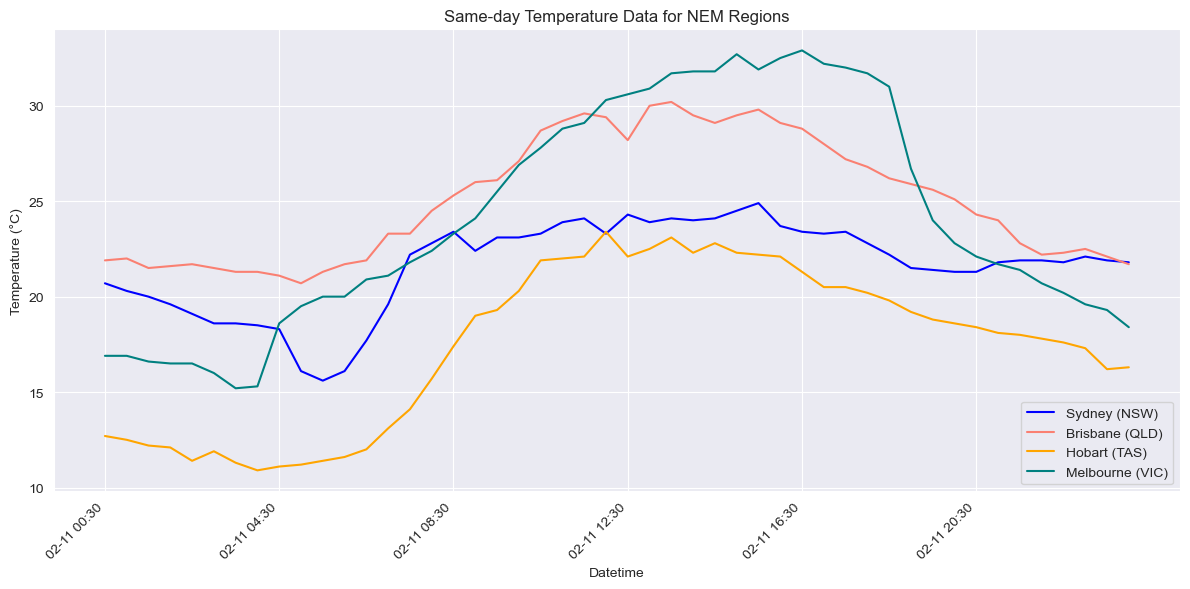

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter

def fetch_region_temperature_data():
    one_week_ago = datetime.now() - timedelta(days=1)
    formatted_date = one_week_ago.strftime('%Y-%m-%d')  # Format the date correctly
    regiontemp = pd.read_csv(f'https://www.neopoint.com.au/Service/Csv?f=301%20Weather%5CNEM%20Cities%20Temperature&from={formatted_date}%2000%3A00&period=Daily&instances=&section=-1&key=PHO2312')
    regiontemp['DateTime'] = pd.to_datetime(regiontemp['DateTime'])
    return regiontemp


def plot_temperature_data(regiontemp):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='DateTime', y='Bankstown.Temperature', data=regiontemp, color='blue', label='Sydney (NSW)')
    sns.lineplot(x='DateTime', y='Brisbane Archerfield Airport.Temperature', data=regiontemp, color='salmon', label='Brisbane (QLD)')
    sns.lineplot(x='DateTime', y='Hobart.Temperature', data=regiontemp, color='orange', label='Hobart (TAS)')
    sns.lineplot(x='DateTime', y='Melbourne Airport (Tullamarine).Temperature', data=regiontemp, color='teal', label='Melbourne (VIC)')

    sns.set_style("darkgrid")
    
    # Generate datetime values at 4-hour intervals
    start_date = regiontemp['DateTime'].min()
    end_date = regiontemp['DateTime'].max()
    midpoints = pd.date_range(start=start_date, end=end_date, freq='4H')
    
    # Rotate and format x-axis labels
    plt.xticks(midpoints, [dt.strftime('%m-%d %H:%M') for dt in midpoints], rotation=45, ha='right')
    
    plt.xlabel('Datetime')
    plt.ylabel('Temperature (°C)')
    plt.title('Same-day Temperature Data for NEM Regions')
    plt.legend(loc='lower right')
    
    # Set Seaborn style to "dark"
    sns.set_style("dark")

    # Set figure size and autolayout parameters
    plt.rcParams["figure.figsize"] = [12.00, 6.00]
    plt.rcParams["figure.autolayout"] = True
    plt.grid(True)
    plt.show()

def main():
    region_temperature_data = fetch_region_temperature_data()
    plot_temperature_data(region_temperature_data)

if __name__ == "__main__":
    main()

## E. Major Constraints for the Week

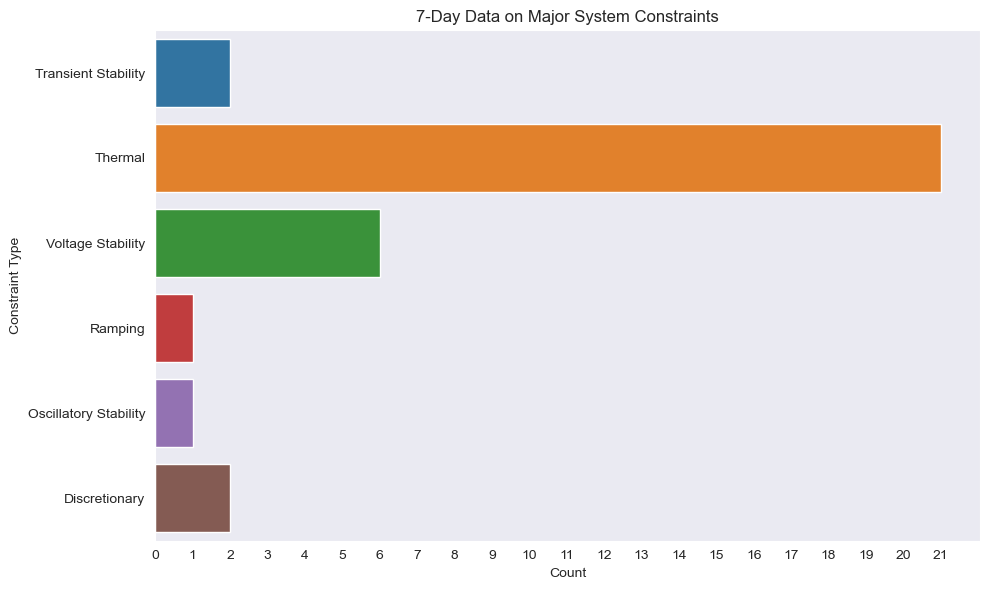

In [13]:
from datetime import datetime, timedelta
import pandas as pd
from urllib.parse import quote
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import math


# Fetching constraint data
current_date = datetime.now().strftime('%Y-%m-%d')
constraint = pd.read_csv(f'https://neopoint.com.au/Service/Csv?f=106%20Flows%20and%20Constraints%5CBinding%20Energy%20constraints%20(gantt)&from={current_date}%2000%3A00&period=Daily&instances=&section=-1&key=PHO2312')
constraint_columns = constraint.columns.str.replace('.Binding', '').tolist()

# Fetching descriptions data for each constraint column
descriptions_list = []
for column_name in constraint_columns:
    encoded_column_name = quote(column_name)
    url = f'https://neopoint.com.au/Service/Csv?f=106%20Flows%20and%20Constraints%5CBinding%20Constraints%20descriptions&from={current_date}%2000%3A00&period=Daily&instances={encoded_column_name}&section=-1&key=PHO2312'
    try:
        response = requests.get(url)
        response.raise_for_status()
        descriptions = pd.read_csv(url)
        descriptions_list.append(descriptions)
    except Exception as e:
        print(f"Error fetching data for column {column_name}: {e}")

# Concatenating fetched dataframes into one
descriptions = pd.concat(descriptions_list, ignore_index=True)

# Filtering data for the past 30 days
date_30_days_ago = datetime.now() - timedelta(days=30)
descriptions['EFFECTIVEDATE'] = pd.to_datetime(descriptions['EFFECTIVEDATE'])
filtered_descriptions = descriptions[descriptions['EFFECTIVEDATE'] >= date_30_days_ago]

# Extracting specific columns from the filtered dataframe
extracted_data = filtered_descriptions[['EFFECTIVEDATE', 'GENCONID', 'LIMITTYPE', 'MODIFICATIONS', 'REASON', 'ADDITIONALNOTES']]

# Fetching and storing data for each constraint column into separate bins
data_bins = {}
for column_name in constraint_columns:
    try:
        encoded_column_name = quote(column_name)
        url = f'https://neopoint.com.au/Service/Csv?f=106%20Flows%20and%20Constraints%5CBinding%20Constraints%20descriptions&from={current_date}%2000%3A00&period=Daily&instances={encoded_column_name}&section=-1&key=PHO2312'
        response = requests.get(url)
        response.raise_for_status()
        descriptions = pd.read_csv(url)
        data_bins[column_name] = descriptions
    except Exception as e:
        print(f"Error fetching data for column {column_name}: {e}")

# Concatenating all dataframes in the data_bins dictionary into one dataframe
combined_data = pd.concat(data_bins.values(), ignore_index=True)

# Sorting entries in descending order based on EFFECTIVEDATE and removing duplicates under the GENCONID column
combined_data = combined_data.sort_values(by='EFFECTIVEDATE', ascending=False)
combined_data = combined_data.drop_duplicates(subset='GENCONID')
filtered_data = combined_data[combined_data['LIMITTYPE'] != 'DEFAULT']

max_count = filtered_data['LIMITTYPE'].value_counts().max()

# Creating a chart from the categorical data in LIMITTYPE column (excluding 'DEFAULT')
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_data, y='LIMITTYPE')
plt.xlabel('Count')
plt.ylabel('Constraint Type')
plt.title('7-Day Data on Major System Constraints')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.xticks(range(math.ceil(max_count) + 1))  
plt.show()